In [2]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [3]:
import os
from sklearn.datasets import load_files
import pandas as pd
raw_data = load_files(os.getcwd() + r'/weizmann Dataset', shuffle=False)
files = raw_data['filenames']

In [4]:
def extract_tag(video_path):
    return (video_path.split("_")[1]).split(".")[0]

In [5]:
data = pd.DataFrame()
data["video_name"] = files
data["tag"] = data["video_name"].apply(extract_tag)



In [6]:
training=data.sample(frac=0.7,random_state=200) #random state is a seed value
testing=data.drop(training.index)

In [7]:
testing.to_csv("tesing.csv")
training.to_csv("training.csv")

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 15
EPOCHS = 500

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [7]:
train_df = pd.read_csv("training.csv")
test_df = pd.read_csv("tesing.csv")
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 65
Total videos for testing: 28


In [8]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [9]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [10]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0,vocabulary=train_df.tag.unique()
)
print(label_processor.get_vocabulary())

['', 'run', 'bend', 'walk', 'skip', 'jump', 'wave1', 'jack', 'side', 'pjump', 'wave2']


In [11]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (65, 20, 2048)
Frame masks in train set: (65, 20)


In [12]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=100,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model




In [13]:
_, sequence_model = run_experiment()

Epoch 1/100
1/2 [==============>...............] - ETA: 0s - loss: 2.4117 - accuracy: 0.0938
Epoch 00001: val_loss improved from inf to 2.48828, saving model to ./tmp\video_classifier
2/2 [==============================] - 3s 1s/step - loss: 2.4089 - accuracy: 0.0667 - val_loss: 2.4883 - val_accuracy: 0.1000
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 2.5438 - accuracy: 0.1250
Epoch 00002: val_loss improved from 2.48828 to 2.43875, saving model to ./tmp\video_classifier
2/2 [==============================] - 0s 134ms/step - loss: 2.4273 - accuracy: 0.2000 - val_loss: 2.4388 - val_accuracy: 0.1000
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 2.3874 - accuracy: 0.1250
Epoch 00003: val_loss improved from 2.43875 to 2.39449, saving model to ./tmp\video_classifier
2/2 [==============================] - 0s 115ms/step - loss: 2.3803 - accuracy: 0.1333 - val_loss: 2.3945 - val_accuracy: 0.1000
Epoch 4/100
1/2 [==============>...............] - ETA: 

Epoch 59/100
1/2 [==============>...............] - ETA: 0s - loss: 1.9159 - accuracy: 0.3125
Epoch 00059: val_loss did not improve from 2.33430
2/2 [==============================] - 0s 16ms/step - loss: 1.8970 - accuracy: 0.2889 - val_loss: 2.3459 - val_accuracy: 0.1000
Epoch 60/100
1/2 [==============>...............] - ETA: 0s - loss: 1.8179 - accuracy: 0.3438
Epoch 00060: val_loss did not improve from 2.33430
2/2 [==============================] - 0s 16ms/step - loss: 1.8835 - accuracy: 0.3333 - val_loss: 2.3552 - val_accuracy: 0.0500
Epoch 61/100
1/2 [==============>...............] - ETA: 0s - loss: 1.9798 - accuracy: 0.2188
Epoch 00061: val_loss did not improve from 2.33430
2/2 [==============================] - 0s 16ms/step - loss: 1.9220 - accuracy: 0.3111 - val_loss: 2.3351 - val_accuracy: 0.1000
Epoch 62/100
1/2 [==============>...............] - ETA: 0s - loss: 1.8868 - accuracy: 0.3125
Epoch 00062: val_loss improved from 2.33430 to 2.31792, saving model to ./tmp\video_cla

1/2 [==============>...............] - ETA: 0s - loss: 1.7768 - accuracy: 0.3125
Epoch 00088: val_loss did not improve from 2.26772
2/2 [==============================] - 0s 19ms/step - loss: 1.7316 - accuracy: 0.3333 - val_loss: 2.3482 - val_accuracy: 0.1000
Epoch 89/100
1/2 [==============>...............] - ETA: 0s - loss: 1.5955 - accuracy: 0.4062
Epoch 00089: val_loss did not improve from 2.26772
2/2 [==============================] - 0s 17ms/step - loss: 1.6498 - accuracy: 0.4000 - val_loss: 2.3056 - val_accuracy: 0.1000
Epoch 90/100
1/2 [==============>...............] - ETA: 0s - loss: 1.6630 - accuracy: 0.4688
Epoch 00090: val_loss improved from 2.26772 to 2.25368, saving model to ./tmp\video_classifier
2/2 [==============================] - 0s 124ms/step - loss: 1.6788 - accuracy: 0.4222 - val_loss: 2.2537 - val_accuracy: 0.1000
Epoch 91/100
1/2 [==============>...............] - ETA: 0s - loss: 1.6147 - accuracy: 0.5000
Epoch 00091: val_loss improved from 2.25368 to 2.23187,

Test video path: D:\college\Vision/weizmann Dataset\wave2\moshe_wave2.avi
  wave1: 18.46%
  pjump: 14.11%
  jack: 12.84%
  jump: 12.78%
  run:  7.42%
  side:  7.19%
  :  6.70%
  walk:  6.37%
  bend:  5.78%
  wave2:  5.06%
  skip:  3.30%



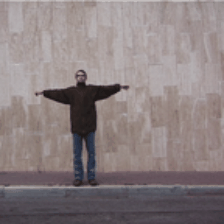

In [14]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])